# Philosophy of bias
What is bias? 
There are many ways it could be defined, but I'm going to use a mathematical definition here: 
$observation = bias \star reality$

Where $observation$ is some quantity that is measured, $reality$ refers to the actual thing that is being studied, and $\star$ is some operation, like addition or convolution. Bias is, by my definition, the signal that is combined with reality in order to produce the observation.

As a simple example of bias, consider the case where you forget to zero out a balance before weighing out a chemical. In this case, 
$measured = offset + weight$

A bias could be random, like a noisy detector. It could be very complex, like if you're trying to study the role of race in income inequality:
$observed cause = bias \star real cause$
where the bias is based on your upbringing, economic assumptions, and any number of other factors. 

In a perfect world, we would like to measure reality. In this case, $bias \star$ would be an identity operator, so that 
$observation = reality$
and we spend a great deal of work making this happen. For example, we use clean pipette tips instead of re-using them. We tare a balance before weighing something. 

An alternative strategy is to characterize the bias and the biasing operator $\star$, so that we can reverse engineer what the reality was:
$reality = observation \star^{-1} bias$

And this is what we do when we perform a control experiment. 
In this notebook, I'm going to discuss how we can use neural networks to control for biases in experimental data. And in order to do that, I'm going to start with...

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
plt.rcParams['figure.figsize'] = [3,2 ]
plt.rcParams['figure.dpi'] = 300


# RF Modulation
How do you communicate information over a radio link? Let's say you want to communicate this string of bits:

In [61]:
NUM_SYMBOLS = 50
bit_pattern = [random.choice([0,1,2,3]) for x in range(NUM_SYMBOLS)]
SIGNAL_DURATION=1
SAMPLING_RATE = 10000
NUM_SAMPLES = SIGNAL_DURATION*SAMPLING_RATE

You could send this bit pattern over the air by applying 0 or 5 volts to an antenna at some known time for each bit.

In [62]:
import math
def binaryToVoltage(message, numSamples):
    voltages = np.zeros((numSamples))
    triggers = np.zeros(len(message))
    stepsPerSymbol = numSamples / len(message)
    for i, symbol in enumerate(message):
        startPos = math.ceil(i * stepsPerSymbol)
        triggers[i] = startPos
        endPos = min(numSamples, math.ceil(startPos + stepsPerSymbol))
        voltages[startPos:endPos] = symbol
    return voltages , triggers

Text(0, 0.5, 'Data value (volts)')

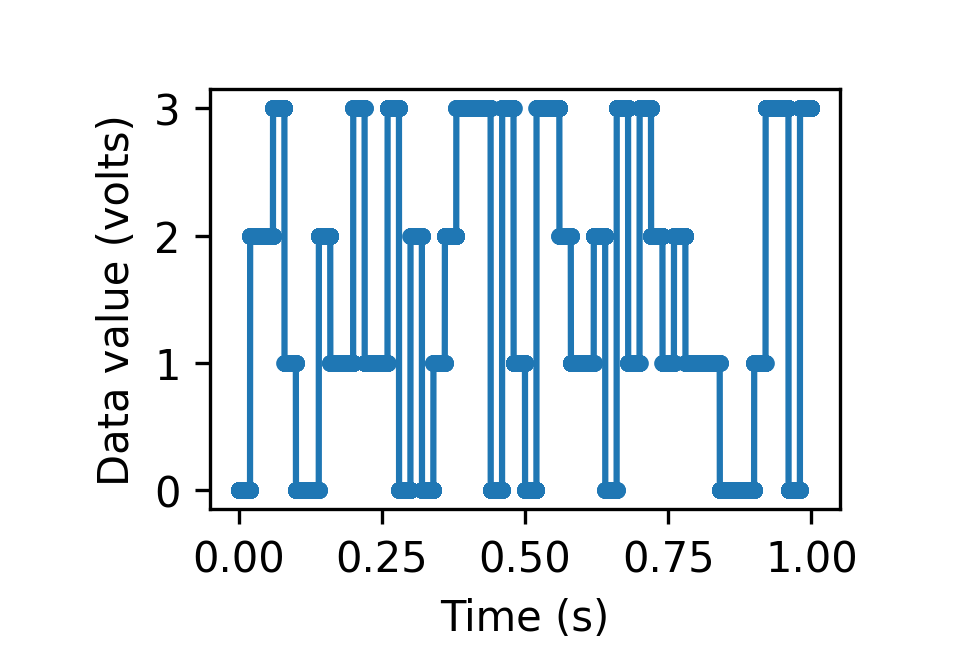

In [63]:
times = np.linspace(0,SIGNAL_DURATION,num=SIGNAL_DURATION*SAMPLING_RATE)
fig = plt.figure()
ax2 = fig.add_axes([0,0,1,1])
ax2.axis('off')
ax = fig.add_axes([0.2, 0.2, 0.7,0.7])

ax.plot(times, binaryToVoltage(bit_pattern, NUM_SAMPLES)[0][:NUM_SAMPLES], '.-')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Data value (volts)")

From that, we could reconstruct the original data. But that's not how the real world works. For one thing, the rest of the world is also transmitting.

In [64]:
import random
#def randomSignal(length):
#    return [random.choice([0,1,2,3]) for x in range(length)]
#background_signals = [binaryToVoltage(randomSignal(NUM_SYMBOLS), SAMPLING_RATE) for x in range(20)]
real_signal, triggers = binaryToVoltage(bit_pattern, NUM_SAMPLES)
#all_signals = [real_signal] + background_signals
#background_signals = np.array(background_signals)
#all_signals = np.array(all_signals)

In [326]:
#How could we go about extracting our data again? It's totally lost with everyone else's transmission. 

Text(0, 0.5, 'Spectral Power')

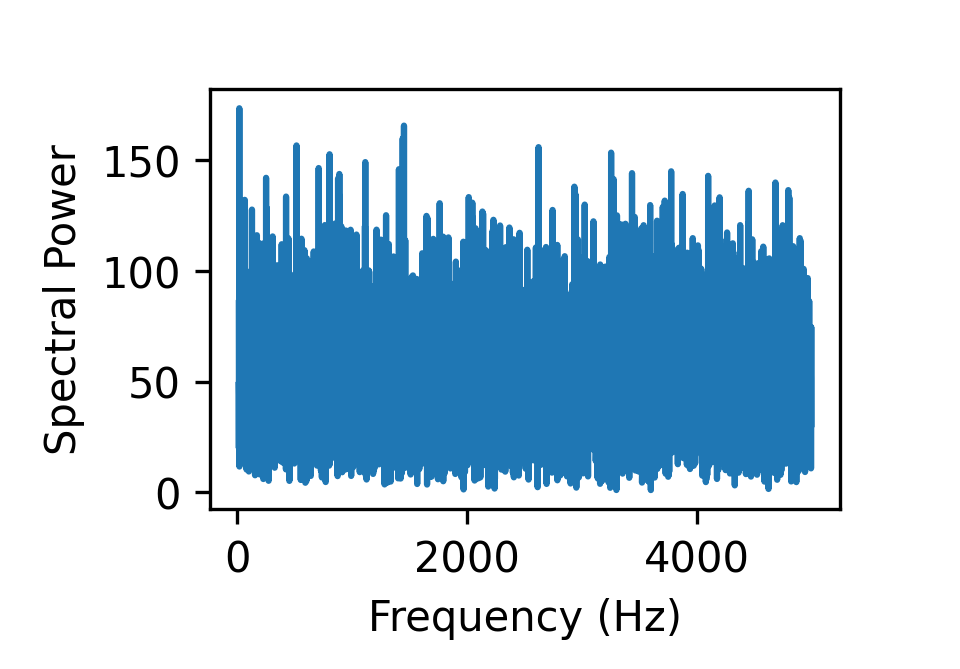

In [65]:
#The answer is to modulate the signal. 
#Let's say that the actual background signal is essentially completely random. 
background_radiation = np.random.uniform(-1, 1, size=NUM_SAMPLES)
#Let's take a look at the Fourier transform of the background radiation.
cfft = np.fft.fft(background_radiation)
freqs = np.fft.fftfreq(background_radiation.shape[0], SIGNAL_DURATION/SAMPLING_RATE)
freqStart = 10
freqEnd = 10000
gofreqs = np.logical_and(freqs > freqStart, freqs < freqEnd)
fig = plt.figure()
ax2 = fig.add_axes([0,0,1,1])
ax2.axis('off')
ax = fig.add_axes([0.2, 0.2, 0.7,0.7])

ax.plot(freqs[gofreqs], np.abs(cfft)[gofreqs], '-')
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Spectral Power")

Text(0, 0.5, 'Spectral Power')

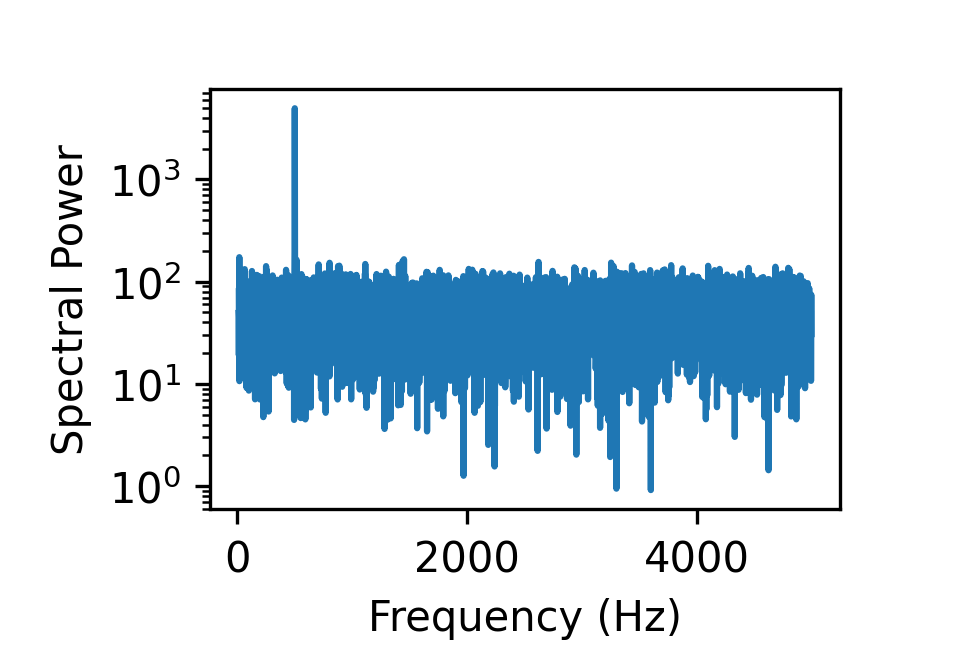

In [72]:
#Let's get a carrier wave at 125 KHz
carrier_freq = 500
carrierTimes = np.linspace(0, carrier_freq * 2 * math.pi * SIGNAL_DURATION, num = NUM_SAMPLES)
carrier = np.cos(carrierTimes)
carrierTrans = background_radiation + carrier
cfft = np.fft.fft(carrierTrans)
freqs = np.fft.fftfreq(carrierTrans.shape[0], SIGNAL_DURATION/SAMPLING_RATE)
freqStart = 10
freqEnd = 10000
gofreqs = np.logical_and(freqs > freqStart, freqs < freqEnd)
fig = plt.figure()
ax2 = fig.add_axes([0,0,1,1])
ax2.axis('off')
ax = fig.add_axes([0.2, 0.2, 0.7,0.7])

#ax.plot(freqs[gofreqs], np.abs(cfft)[gofreqs], '-')
ax.semilogy(freqs[gofreqs], np.abs(cfft)[gofreqs])
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Spectral Power")


Bbox(x0=0.2, y0=0.2, x1=0.8999999999999999, y1=0.8999999999999999)


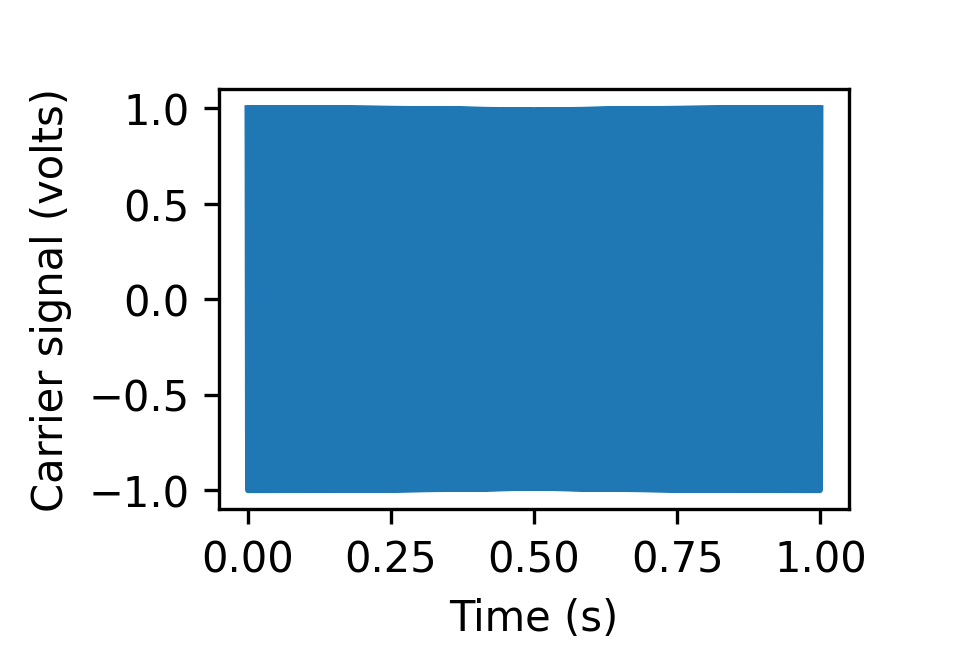

In [73]:
fig = plt.figure()
ax2 = fig.add_axes([0,0,1,1])
ax2.axis('off')
ax = fig.add_axes([0.2, 0.2, 0.7,0.7])
ax.plot(times, carrier)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Carrier signal (volts)")
print(ax.get_position())

Text(0, 0.5, 'Spectral Power')

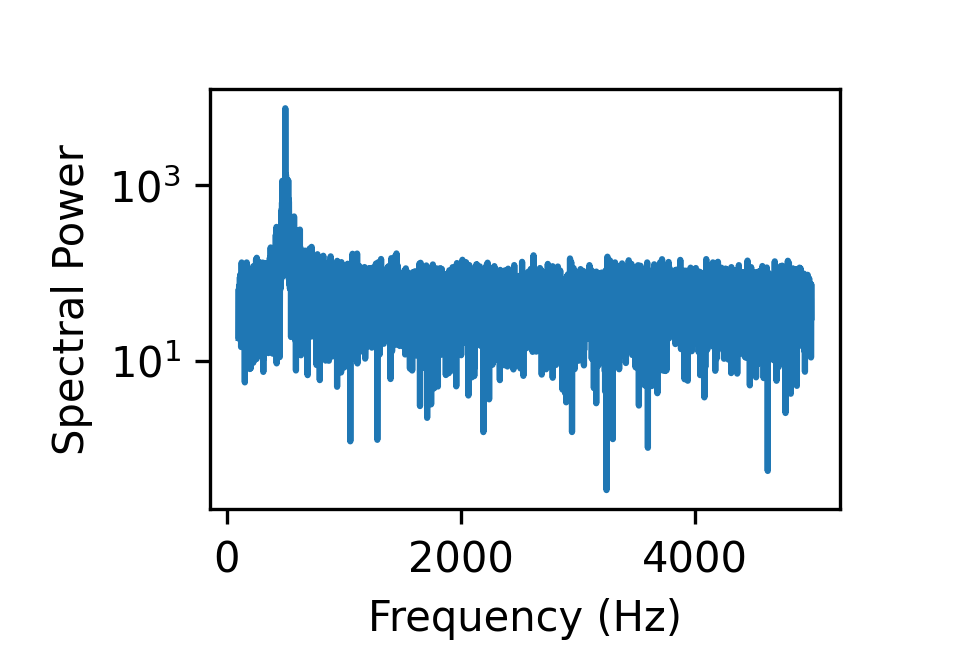

In [74]:
#So now we're transmitting a 125 KHz signal, and it clearly shows up above the noise. But we're not transmitting any data. 
modulatedCarrier = real_signal * carrier
carrierTrans = background_radiation + modulatedCarrier
cfft = np.fft.fft(carrierTrans)
freqs = np.fft.fftfreq(carrierTrans.shape[0], SIGNAL_DURATION/SAMPLING_RATE)
freqStart = 100
freqEnd = 10000
gofreqs = np.logical_and(freqs > freqStart, freqs < freqEnd)
fig = plt.figure()
ax2 = fig.add_axes([0,0,1,1])
ax2.axis('off')
ax = fig.add_axes([0.2, 0.2, 0.7,0.7])

#ax.plot(freqs[gofreqs], np.abs(cfft)[gofreqs], '-')
ax.semilogy(freqs[gofreqs], np.abs(cfft)[gofreqs])
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Spectral Power")


Text(0, 0.5, 'Transmitted signal (volts)')

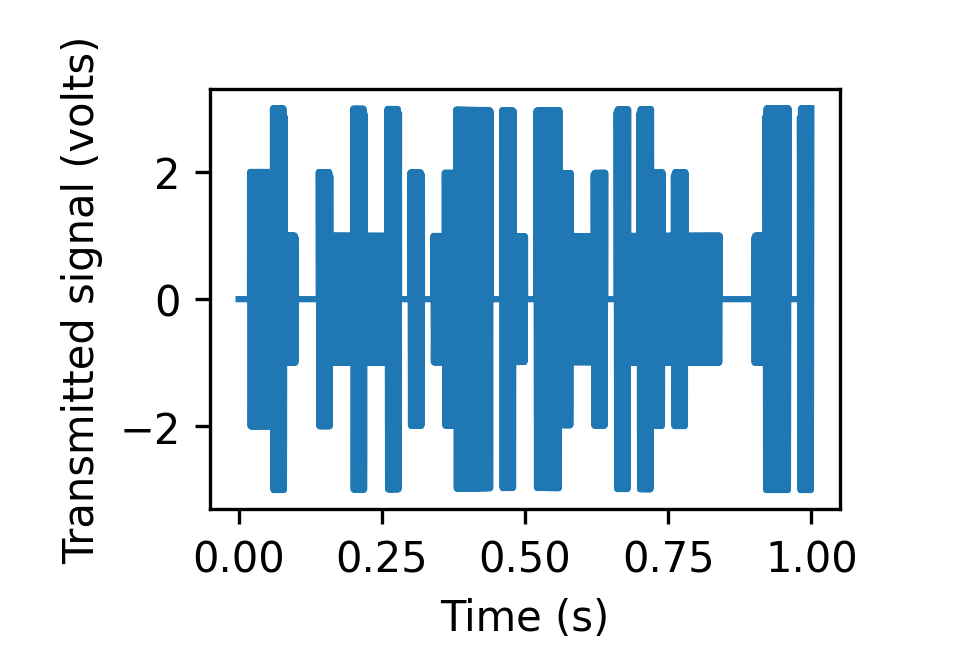

In [75]:
fig = plt.figure()
ax2 = fig.add_axes([0,0,1,1])
ax2.axis('off')
ax = fig.add_axes([0.2, 0.2, 0.7,0.7])
ax.plot(times, modulatedCarrier[:NUM_SAMPLES])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Transmitted signal (volts)")

Text(0, 0.5, 'Received signal (volts)')

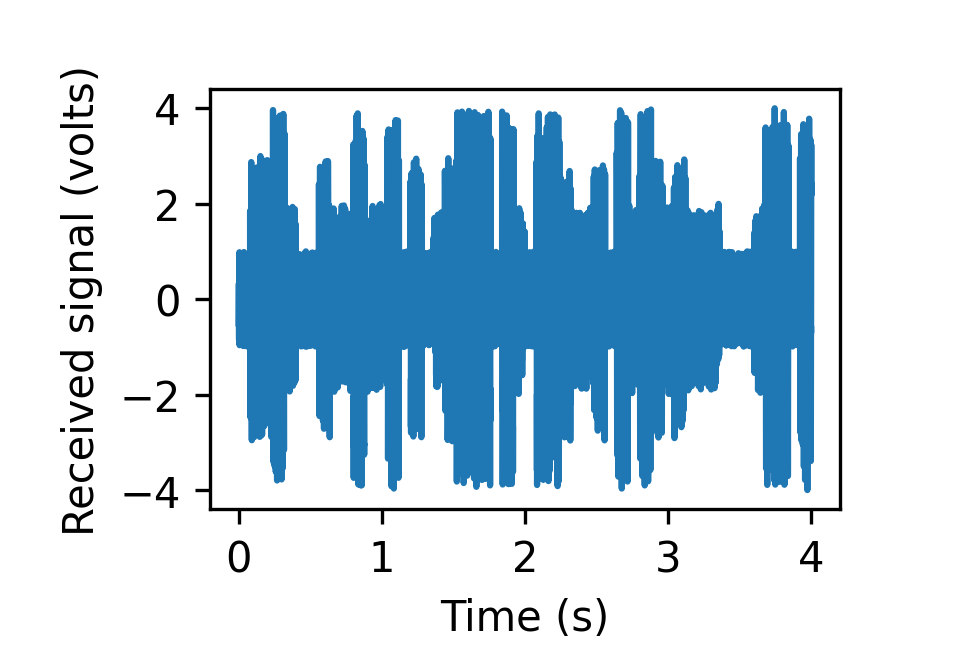

In [76]:
#We see that the modulated signal occupies more bandwidth, and let's take a look at that signal in the time domain. 
fig = plt.figure()
ax2 = fig.add_axes([0,0,1,1])
ax2.axis('off')
ax = fig.add_axes([0.2, 0.2, 0.7,0.7])
ax.plot(times*4, carrierTrans[:NUM_SAMPLES])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Received signal (volts)")

Text(0, 0.5, 'Mixer output (volts)')

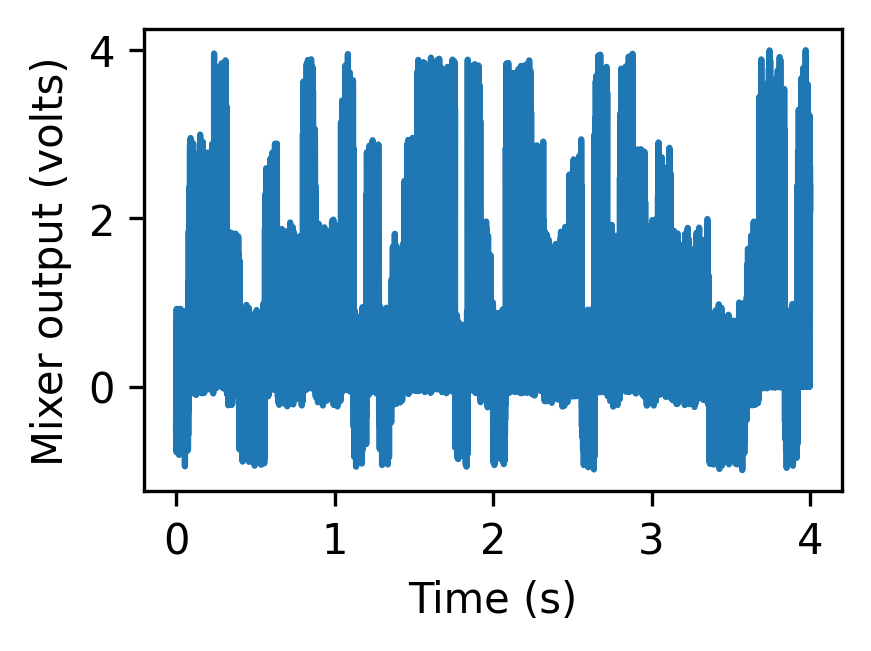

In [82]:
#Looks noisy. 
#How can we recover the transmitted data? Without going too deep into modulation theory, we can "mix" the transmitted signal with the original
#carrier (the receiver will have to make their own carrier) and recover the transmitted data:
mixed = carrier * carrierTrans
plt.plot(times*4, mixed, '-')
plt.xlabel("Time (s)")
plt.ylabel("Mixer output (volts)")

Text(0, 0.5, 'Recovered signal (volts)')

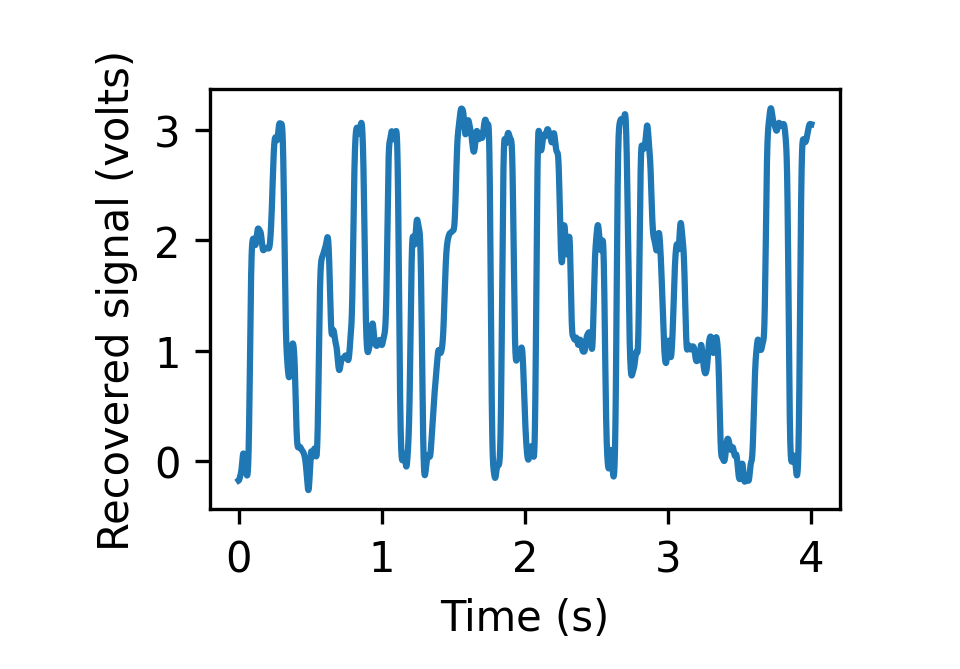

In [83]:
#We can see that the data are in the mixed signal, but we need to smooth it a bit to actually recover the transmitted data:
import scipy.ndimage
mixedSmoothed = scipy.ndimage.gaussian_filter1d(mixed, 20)
#plt.plot(times*4, real_signal[:10000])
fig = plt.figure()
ax2 = fig.add_axes([0,0,1,1])
ax2.axis('off')
ax = fig.add_axes([0.2, 0.2, 0.7,0.7])
ax.plot(times*4, mixedSmoothed[:NUM_SAMPLES]*2)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Recovered signal (volts)")


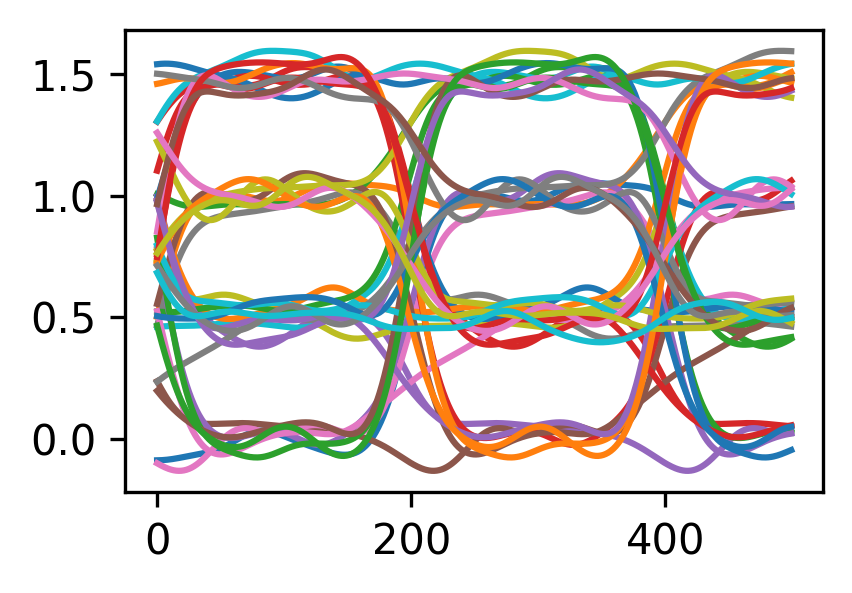

In [84]:
#Here's something called an eye diagram, where we basically overlay all of the transitions between bit states. 
for i, trig in enumerate(triggers[:-10]):
    if(i > 500):
        break
    dat = mixedSmoothed[int(trig):int(trig)+500]
    xval = np.arange(0,500)
    plt.plot(xval, dat)

In [ ]:
#It looks like we've recovered the different input states pretty cleanly. Awesome! 

# Genomics signals are modulated.


In [89]:
#Let's take a look at a random stretch of data. In this case, I'll be using an mnase dataset. 
import pyBigWig
mnaseBw = pyBigWig.open("mnase_data.bw")

#I also have a dataset of mnase data collected from naked DNA. This should capture what the enzyme would do if there were no nucleosomes 
#block it. 
biasBw = pyBigWig.open("mnase_bias.bw")

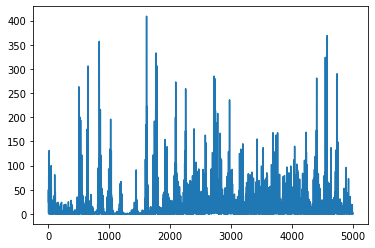

In [94]:
#Let's take a look at a random region.
mnaseVals = np.nan_to_num(mnaseBw.values("chrI", 10000, 15000))
plt.plot(mnaseVals)

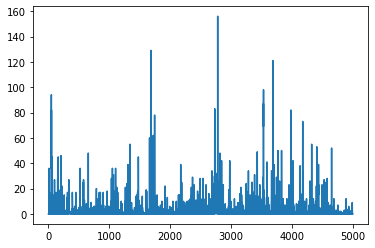

In [95]:
#We see a bunch of well-defined nucleosomes here, and what looks like an NDR around position 1250. 
#But now let's take a look at the naked dna result in this same region.
biasVals = np.nan_to_num(biasBw.values("chrI", 10000, 15000))
plt.plot(biasVals)

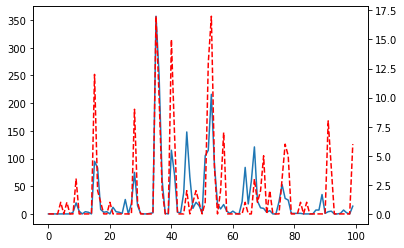

In [106]:
#They look pretty different. But let's now zoom in.
boundsL, boundsR = 800,900
plt.plot(mnaseVals[boundsL:boundsR])
plt.gca().twinx()
plt.plot(biasVals[boundsL:boundsR], 'r--')

In [123]:
#On this  microscale, it does seem that the two signals could be correlated. 
#How about chromosome-wide, are they correlated there? 
mnaseChromI = np.nan_to_num(mnaseBw.values("chrI", 1000, mnaseBw.chroms("chrI") - 1000))
biasChromI = np.nan_to_num(biasBw.values("chrI", 1000, mnaseBw.chroms("chrI") - 1000))
#Also normalize the data, because there are more reads on the mnase dataset than the bias dataset.
mnaseChromI /= np.mean(mnaseChromI)
biasChromI /= np.mean(biasChromI)

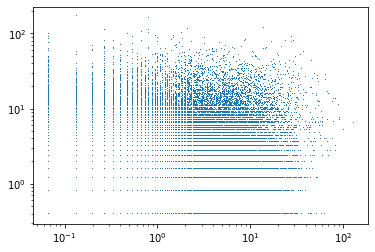

In [124]:
plt.loglog(mnaseChromI, biasChromI, ',')

In [125]:
#It's hard to tell at first blush if those are correlated. 

In [126]:
import scipy.stats
print(scipy.stats.linregress(mnaseChromI, biasChromI))

LinregressResult(slope=0.311314012464714, intercept=0.6886859875352858, rvalue=0.2465984853819653, pvalue=0.0, stderr=0.002561012873680694, intercept_stderr=0.0073455724979400875)


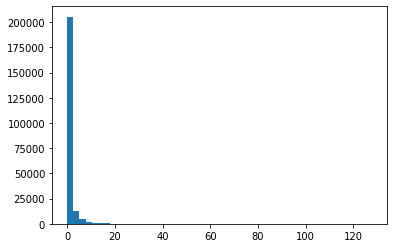

In [127]:
#They're definitely correlated, but it's not a clean relationship. 
#I bet it's because a lot of mnase regions have zero reads, since they're covered by nucleosomes. 
plt.hist(mnaseChromI, bins=50);

LinregressResult(slope=0.11825248934521677, intercept=4.866281181612912, rvalue=0.10214149129998908, pvalue=2.1077489547040968e-50, stderr=0.007899696143654782, intercept_stderr=0.06268964565511746)


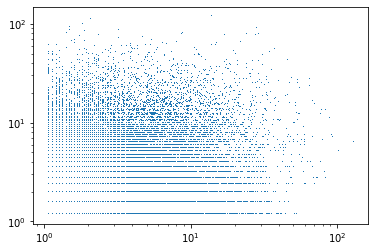

In [133]:
#Yup. Let's get rid of the bases that have zero reads, and just correlate where we actually have data.
basesWithReads = np.logical_and(mnaseChromI > 1, biasChromI > 1)
readMnase = mnaseChromI[basesWithReads]
readBias = biasChromI[basesWithReads]
plt.loglog(readMnase, readBias, ',')
print(scipy.stats.linregress(readMnase, readBias))

In [151]:
readOrder = np.argsort(readMnase)

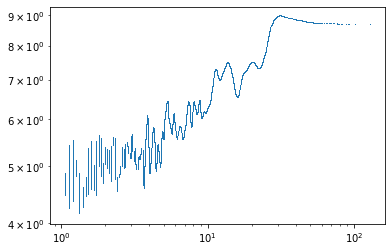

In [156]:

smoothBias = scipy.ndimage.gaussian_filter1d(readBias[readOrder], 100)

plt.loglog(readMnase[readOrder] , smoothBias,',')

In [ ]:
#This is data-massaging in the worst way, but when we look at the overall trend for each read count in the mnase data, we 
#clearly see that high read counts in the mnase data mirror high counts in the bias track. 

In [195]:
import scipy.stats
ret = scipy.stats.binomtest(17, 17, p=0.76)
print(ret)

BinomTestResult(k=17, n=17, alternative='two-sided', proportion_estimate=1.0, pvalue=0.01879708366332914)


# Convolution

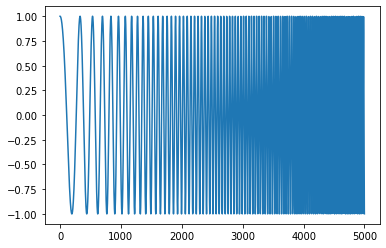

In [238]:
#Let's take a chirp wave. 
frequencies = np.linspace(1,10, num=5000)
times = np.linspace(0,60, num=5000)
signal = np.cos(times * frequencies)
plt.plot(signal)

(0.0, 5000.0)

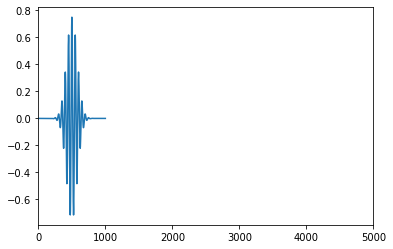

In [243]:
mor = scipy.signal.morlet(1000, 10)
plt.plot(np.real(mor))
plt.xlim(0,5000)

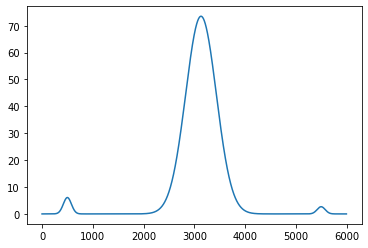

In [242]:
conv = np.convolve(signal, mor)
plt.plot(np.abs(conv))

(0.0, 5000.0, -3.6752426521204677, 77.18009573869514)

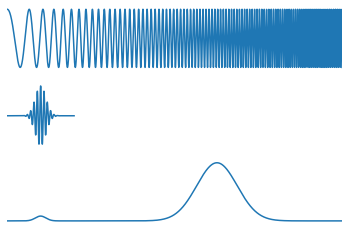

In [249]:
plt.subplot(311)
plt.plot(signal)
plt.xlim(0,5000)
plt.axis('off')
plt.subplot(312)
plt.plot(np.real(mor))
plt.xlim(0,5000)
plt.axis('off')
plt.subplot(313)
plt.xlim(0,5000)
plt.plot(np.abs(conv))
plt.axis('off')